In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 64
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 128
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [5]:
#data aug
print('length of training set before data augmentation', len(trainset))
dataaug = transforms.Compose([
                transforms.Resize((size, size)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(0.75),
                transforms.RandomRotation(45),
                transforms.RandomVerticalFlip(0.75),
#                 transforms.RandomPerspective(),
                transforms.RandomResizedCrop(size),
#                 transforms.GaussianBlur(3),
        ])

dataaugtrainset = Hotdog_NotHotdog(train=True, transform=dataaug)
dataaugtrainsetLoader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)


length of training set before data augmentation 2047


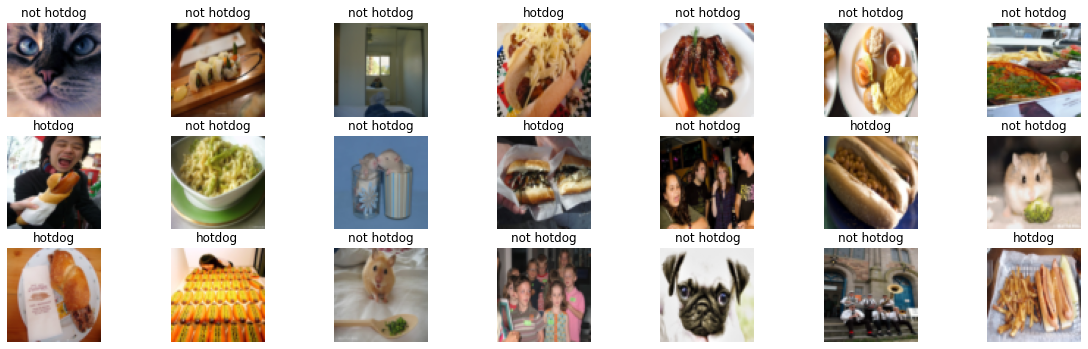

In [6]:
images, labels = next(iter(dataaugtrainsetLoader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)

    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [7]:
# trainset += dataaugtrainset
print('length of training set after data augmentation', len(trainset))

length of training set after data augmentation 2047


Let's look at some images from our data 

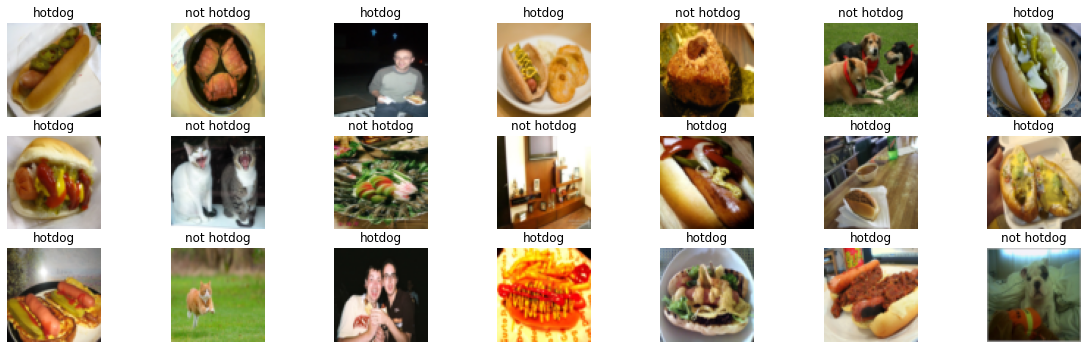

In [8]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)

    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [9]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Now create a model and train it!


In [10]:
dropout_rate = 0.2
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Dropout2d(dropout_rate),
                nn.Conv2d(3, 8, kernel_size=3, padding='same', stride=1),
                nn.BatchNorm2d(8),
                nn.Dropout2d(dropout_rate),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, padding='same', stride=1),
                nn.BatchNorm2d(8),
                nn.Dropout2d(dropout_rate),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, padding='same', stride=1),
                nn.BatchNorm2d(16),
                nn.Dropout2d(dropout_rate),
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, padding='same', stride=1),
                nn.BatchNorm2d(16),
                nn.Dropout2d(dropout_rate),
                nn.ReLU(),
                
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(int(size/2)*int(size/2)*16, 500),
                nn.ReLU(),
                nn.Linear(500, 2),
#                 nn.Softmax(dim=1),
                nn.LogSoftmax(dim=1),
        )
        
        
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
 
        x = self.fully_connected(x)
        return x

In [11]:
model = Network()
model.to(device)

#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer2 = torch.optim.Adam(model2.parameters(),lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
criterion = nn.NLLLoss()

In [12]:
def train(model, optimizer, num_epochs=20):
    def loss_fun(output, target):
#         return F.nll_loss(torch.log(output), target)
        return criterion(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [13]:
out_dict = train(model, optimizer, 20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.706	 test: 0.693	 Accuracy train: 52.5%	 test: 54.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.689	 test: 0.682	 Accuracy train: 54.5%	 test: 57.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.677	 test: 0.694	 Accuracy train: 57.3%	 test: 49.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.660	 test: 0.670	 Accuracy train: 60.7%	 test: 57.4%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.641	 test: 0.666	 Accuracy train: 63.2%	 test: 59.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.640	 test: 0.628	 Accuracy train: 63.5%	 test: 66.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.614	 test: 0.616	 Accuracy train: 67.5%	 test: 68.5%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.619	 test: 0.610	 Accuracy train: 67.1%	 test: 69.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.604	 test: 0.619	 Accuracy train: 67.5%	 test: 67.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.595	 Accuracy train: 68.0%	 test: 70.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.579	 test: 0.628	 Accuracy train: 68.9%	 test: 66.6%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.544	 test: 0.621	 Accuracy train: 71.6%	 test: 64.3%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.539	 test: 0.595	 Accuracy train: 72.4%	 test: 68.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.605	 Accuracy train: 74.0%	 test: 68.2%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.525	 test: 0.660	 Accuracy train: 73.5%	 test: 65.0%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.501	 test: 0.604	 Accuracy train: 75.2%	 test: 67.8%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.465	 test: 0.621	 Accuracy train: 77.5%	 test: 67.3%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.460	 test: 0.649	 Accuracy train: 77.0%	 test: 66.4%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.428	 test: 0.665	 Accuracy train: 80.1%	 test: 66.9%


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.413	 test: 0.612	 Accuracy train: 81.0%	 test: 70.3%


Text(0, 0.5, 'Accuracy')

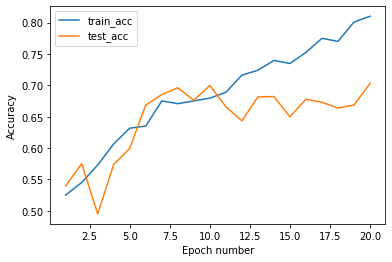

In [14]:
# print(len(out_dict['train_acc'])) #73.8%	 test: 73.4%
plt.plot(range(1, len(out_dict['train_acc'])+1), out_dict['train_acc'])
# plt.plot(range(1, len(out_dict1['train_loss'])+1), out_dict1['train_loss'])
plt.plot(range(1, len(out_dict['test_acc'])+1), out_dict['test_acc'])
# plt.plot(range(1, len(out_dict1['test_loss'])+1), out_dict1['test_loss'])

# plt.plot(range(1, len(out_dict2['train_acc'])+1), out_dict2['train_acc'])
# # plt.plot(range(1, len(out_dict2['train_loss'])+1), out_dict2['train_loss'])
# plt.plot(range(1, len(out_dict2['test_acc'])+1), out_dict2['test_acc'])


plt.legend(('train_acc','test_acc'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [291]:
#salicancy map

def m_c_hat(x,N,mean=0,std=0.1):
    smooth = 0
    for i in range(N):
        smooth  =+ m_c(x + (torch.randn(x.size()) * std + mean))
    return smooth / N

def m_c(x):
    x.requires_grad_()
    x.to(device)
    scores = model(x)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index]

    score_max.backward()
    
    saliency, _ = torch.max(x.grad.data.abs(), dim=1) 
    return saliency

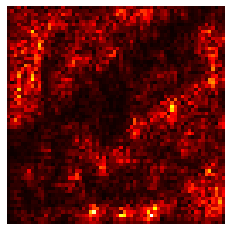

In [292]:
images, labels = next(iter(test_loader))

model.to('cpu')
model.eval()

X = images[0,:,:,:]
X = X[None,:,:,:]

saliency = m_c_hat(X,10)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()


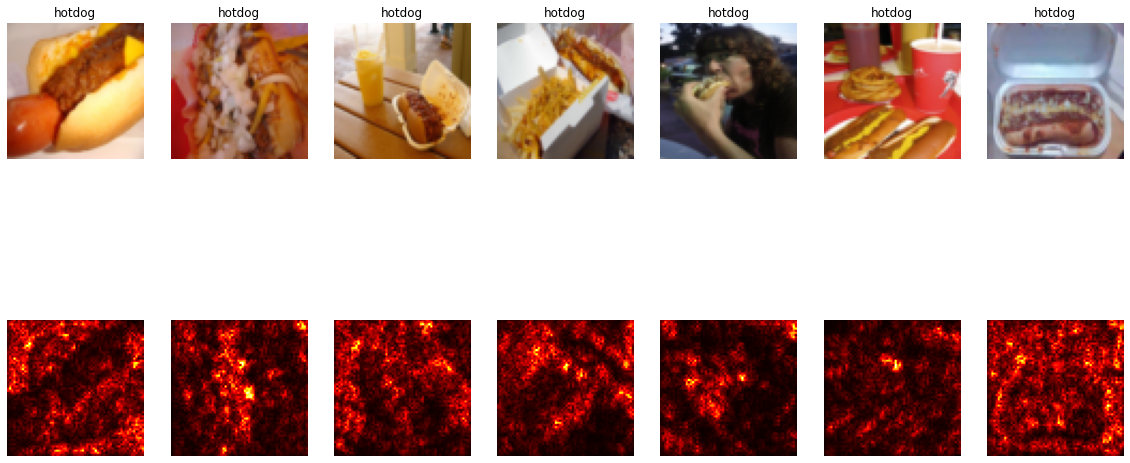

In [297]:

fig, axs = plt.subplots(2,7,figsize=(20,10))


images, labels = next(iter(test_loader))

model.to('cpu')
model.eval()

for i in range(7):
    X = images[i,:,:,:]
    X = X[None,:,:,:]

    saliency = m_c_hat(X,10)
    
    axs[0,i].imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    axs[0,i].title.set_text(['hotdog', 'not hotdog'][labels[i].item()])
    axs[1,i].axis('off')
    axs[0,i].axis('off')
    axs[1,i].imshow(saliency[0], cmap=plt.cm.hot)
#     axs[1,i].imshow(saliency[0])



In [169]:
# save
## torch.save(im, PATH)
# PATH = 'model.pt'

# torch.save(model.state_dict(), PATH)

In [17]:
# laod model
# model = Network(*args, **kwargs)
# model = Network()
# model.load_state_dict(torch.load(PATH,map_location="cuda"))
# model.eval()